# Sentiment Polarity Prediction with Naive Bayes

This notebook contains a basic implementation of document-level sentiment analysis
for movie reviews with multinomial Naive Bayes and bag-of-words features
and of cross-validation.
* No special treatment of rare or unknown words. Unknown words in the test data are skipped.

We use the movie review polarity data set of Pang and Lee 2004 [A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts](https://www.aclweb.org/anthology/P04-1035/) in Version 2.0 available from http://www.cs.cornell.edu/People/pabo/movie-review-data (section "Sentiment polarity datasets"). This dataset contains 1000 positive and 1000 negative reviews, each tokenised, sentence-split (one sentence per line) and lowercased. Each review has been assigned to 1 of 10 cross-validation folds by the authors and this setup should be followed to compare with published results.


# -----------------------------------------------------------------------------------------------------------------

# Setup

### Import packages

In [1]:
# general packages
import os
import time
import pandas as pd
from tqdm.auto import tqdm

In [26]:
# models needed for modelling
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

### Import the classes and functions from the '.py' file

In [3]:
%load_ext autoreload
%autoreload 1
%aimport Classes_and_functions

import Classes_and_functions as py

### Define the location of my chromedriver

In [4]:
chromedriver_location = 'C:\\Program Files (x86)\\Google\\Chrome\\Application\\chromedriver.exe'

# -----------------------------------------------------------------------------------------------------------------

# Load in the data

In [5]:
data_dict = py.load_data('data', chromedriver_location)

### Preview the documents in the data

In [6]:
fold = 0
for label in ['pos', 'neg']:
    print('\n====', label, '====')
    
    output_df = pd.DataFrame(columns=['doc_num', 'sentences', 'start_of_first_sentence'])
    
    list_of_documents = py.get_documents(data_dict, fold, label)
    for doc_num, document in enumerate(list_of_documents):
        
        doc_preview = py.get_document_preview(document, max_length=50)
        
        one_row = pd.DataFrame({'doc_num': doc_num, 'sentences': len(document), 'start_of_first_sentence': doc_preview}, index=[0])
        output_df = pd.concat([output_df, one_row], axis=0).reset_index(drop=True)
        
    print(output_df.to_markdown())


==== pos ====
   doc_num sentences                            start_of_first_sentence
0        0        25  films|adapted|from|comic|books|have|had|plenty|of
1        1        39      every|now|and|then|a|movie|comes|along|from|a
2        2        19  you've|got|mail|works|alot|better|than|it|dese...
3        3        42  "|jaws|"|is|a|rare|film|that|grabs|your|attention
4        4        25        moviemaking|is|a|lot|like|being|the|general
..     ...       ...                                                ...
95      95        26               "|crazy/beautiful|"|suffers|from|the
96      96        29  everyone|knows|someone|like|giles|de'ath|:|stuffy
97      97        51  for|many|people|,|procrastination|isn't|a|problem
98      98        26         meet|joe|black|(|reviewed|on|nov|.|27/98|)
99      99        48      call|it|touched|by|a|demon|.|gregory|hoblit's

[100 rows x 3 columns]

==== neg ====
   doc_num sentences                            start_of_first_sentence
0        0

# -----------------------------------------------------------------------------------------------------------------

# Create training-test splits for Cross-Validation

In [7]:
train_test_splits = py.get_train_test_splits(data_dict)

### Show the splits

In [8]:
num_docs_in_split = pd.DataFrame(columns=["train_set_size", "test_set_size"])

for train_data, test_data in train_test_splits:
    one_row = pd.DataFrame({"train_set_size": len(train_data), "test_set_size": len(test_data)}, index=[0])
    num_docs_in_split = pd.concat([num_docs_in_split, one_row], axis=0)
    
num_docs_in_split.reset_index(drop=True)

,train_set_size,test_set_size
0,1800,200
1,1800,200
2,1800,200
3,1800,200
4,1800,200
5,1800,200
6,1800,200
7,1800,200
8,1800,200
9,1800,200


# -----------------------------------------------------------------------------------------------------------------

# Define the Naive Bayes model

In [32]:
#model = py.Model(model=MultinomialNB())
#model = py.Model(model=LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200))
#model = py.Model(SGDClassifier())
model = py.Model(RandomForestClassifier())

### Measure the model performance using one train-test split

In [33]:
sample_train_data, sample_test_data = train_test_splits[0]
model.train(sample_train_data)
py.print_first_n_predictions(model, sample_test_data, num_predictions=10, len_preview=50)

Accuracy = 0.84
Confusion_matrix:
 [[86 14]
 [18 82]]


,label,prediction,documents
0,pos,neg,films|adapted|from|comic|books|have|had|plenty|of
1,pos,pos,every|now|and|then|a|movie|comes|along|from|a
2,pos,pos,you've|got|mail|works|alot|better|than|it|dese...
3,pos,pos,"""|jaws|""|is|a|rare|film|that|grabs|your|attention"
4,pos,neg,moviemaking|is|a|lot|like|being|the|general
5,pos,pos,"on|june|30|,|1960|,|a|self-taught|,|idealistic|,"
6,pos,pos,"apparently|,|director|tony|kaye|had|a|major|ba..."
7,pos,pos,one|of|my|colleagues|was|surprised|when|i|told...
8,pos,pos,"after|bloody|clashes|and|independence|won|,"
9,pos,pos,the|american|action|film|has|been|slowly|drowning


### Measure the model performance Cross-Validating across all train-test splits

In [35]:
py.evaluate_model(model, train_test_splits, fold_verbose=True)

Fold 1 of 10 --> 0.815
Fold 2 of 10 --> 0.88
Fold 3 of 10 --> 0.835
Fold 4 of 10 --> 0.865
Fold 5 of 10 --> 0.83
Fold 6 of 10 --> 0.86
Fold 7 of 10 --> 0.87
Fold 8 of 10 --> 0.885
Fold 9 of 10 --> 0.86
Fold 10 of 10 --> 0.88


,Avg accuracy,Root mean square error,Minimum accuracy,Maximum accuracy
0,0.858,0.022494,0.815,0.885


# -----------------------------------------------------------------------------------------------------------------

# Compare different models

### Choose the models to use and the parameters to experiment with

Default models
 - sklearn.naive_bayes.MultinomialNB(*, alpha=1.0, fit_prior=True, class_prior=None)
 - sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 - sklearn.linear_model.SGDClassifier(loss='hinge', *, penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
 - sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In [27]:
model_dict = {#MultinomialNB(): "Naive Bayes",
              #LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200): "Logistic Regression",
              #SGDClassifier(): "Support Vector Machine",
              RandomForestClassifier(): "Random Forest",
             }

clip_counts_dict = {True: "with clip counts",
                    False: "no clip counts",
                   }

ngram_size_dict = {1: "Unigram",
                   2: "Bigram",
                   3: "Trigram",
                  }

### Define the models with the varying parameters

In [28]:
models_to_compare = define_models_with_params(model_dict, ngram_size_dict, clip_counts_dict)

{'Unigram Random Forest with clip counts': <Classes_and_functions.Model at 0x257aa1f7be0>,
 'Unigram Random Forest no clip counts': <Classes_and_functions.Model at 0x257aa1f7c10>,
 'Bigram Random Forest with clip counts': <Classes_and_functions.Model at 0x257aa1f7c70>,
 'Bigram Random Forest no clip counts': <Classes_and_functions.Model at 0x257aa1f7d60>,
 'Trigram Random Forest with clip counts': <Classes_and_functions.Model at 0x257aa1f7df0>,
 'Trigram Random Forest no clip counts': <Classes_and_functions.Model at 0x257aa1f7e50>}

### Train & test these models to compare them


Unigram Random Forest with clip counts


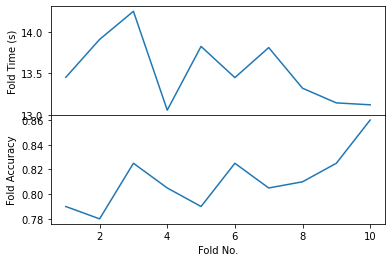


Unigram Random Forest no clip counts



KeyboardInterrupt: 

In [77]:
eval_df = pd.DataFrame()
for model_name, model in tqdm(models_to_compare.items()):
    print("\n" + model_name)
    model_eval_df = py.evaluate_model(model_name, model, train_test_splits, fold_verbose=False, plot_folds=True)
    eval_df = pd.concat([eval_df, model_eval_df], axis=0).reset_index(drop=True)

### Manually inspect the evaluation scores

In [78]:
eval_df

,Model,Avg Accuracy,Root Mean Squared Error,Min Accuracy,Max Accuracy,Total Time (s),All Fold Averages
0,Unigram Random Forest with clip counts,0.8115,0.022142,0.78,0.86,135.57,"[0.79, 0.78, 0.825, 0.805, 0.79, 0.825, 0.805,..."


### Store the comparison of the different models

In [79]:
filepath = os.path.join("data", "model_evaluation_scores.csv")
eval_df.to_csv(filepath, index=False)

# -----------------------------------------------------------------------------------------------------------------

In [ ]:
break!

# Old Run

In [38]:
eval_df

,Model,Accuracy,Stddev,Min,Max,Duration (s)
0,Unigram Naive Bayes with clip_counts,0.8270,0.020761,0.785,0.855,41.099505
1,Unigram Naive Bayes no clip_counts,0.8165,0.028814,0.760,0.850,48.668412
2,Bigram Naive Bayes with clip_counts,0.8580,0.022494,0.815,0.885,229.376951
3,Bigram Naive Bayes no clip_counts,0.8420,0.024515,0.800,0.880,228.880124
4,Trigram Naive Bayes with clip_counts,0.7840,0.022000,0.750,0.820,864.413064
5,Trigram Naive Bayes no clip_counts,0.7810,0.011790,0.760,0.800,779.532211


In [25]:
eval_df

,Model,Accuracy,Stddev,Min,Max,Duration (s)
0,Unigram Support Vector Machine with clip counts,0.8415,0.025695,0.790,0.880,45.02
1,Unigram Support Vector Machine no clip counts,0.8090,0.046087,0.685,0.865,85.20
2,Bigram Support Vector Machine with clip counts,0.8160,0.021772,0.790,0.865,1225.93
3,Bigram Support Vector Machine no clip counts,0.7975,0.020767,0.755,0.830,1121.27


In [18]:
eval_df

,Model,Accuracy,Stddev,Min,Max,Duration (s)
0,Unigram Logistic Regression with clip counts,0.8675,0.019653,0.84,0.91,2538.34


In [72]:
eval_df

,Model,Duration (s),Accuracy,Root MSE,Min,Max
0,Unigram Random Forest with clip counts,136.48,0.820,0.030984,0.775,0.875
1,Unigram Random Forest no clip counts,138.66,0.787,0.021703,0.750,0.830
